## Conditional Variational Autoencoder: A Keras Implementation of Attribute2Image
#### by Shin-Yi Chu

The original Attribute2Image paper suggested a disCVAE model that uses two conditional variational autoencoders in parallel to encode and produce images of faces and their background images. I have decided to take only the encoder part of the model proposed in the paper, and add a few minor adjustments. Instead of pooling or upsampling, the model in this notebook uses convolutional and transposed-convolutional (deconvolutional) layers with strides set to adjust the dimensions of the intermediate tensors accordingly.

First off, we must import the necessary packages from Keras, especially the layers we will use.

In [29]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Flatten, Dense, Lambda, Reshape, concatenate, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard

Next, we load the data. I have already prepared custom h5 files containing all necessary training data, which are cropped versions of the LFW (Labelled Faces in the Wild) dataset, and a custom function to import said data. For the purposes of this notebook, ignore __g_train__ and __g_test__. __x_train__ and __x_test__ are the image data for testing and training respectively, while __y_train__ and __y_test__ are the attribute data for the testing and training respectively.

In [10]:
import numpy as np
import h5py

def h5_to_np():
    train_file = h5py.File('lfw_train.h5', 'r')
    traindat = train_file['trainData'][:], train_file['trainAttr'][:], train_file['trainMask'][:]
    train_file.close()
    
    test_file = h5py.File('lfw_test.h5', 'r')
    testdat = test_file['testData'][:], test_file['testAttr'][:], test_file['testMask'][:]
    test_file.close()
    
    return traindat, testdat

(x_train, y_train, g_train), (x_test, y_test, g_test) = h5_to_np()

Before we set up the autoencoder, let's also define some variables that will be used throughout, pertaining especially to the dimensions of our tensors.

In [20]:
image_dim = x_train.shape[1]
cols = x_train.shape[3]
att_cols = y_train.shape[1]

epochs = 50
latent_dim = 256
batch_size = 64

Now, let's set up the architecture of a conditional variational autoencoder. We should start with the encoder, which encodes input images with attribute information into a lower dimensional latent space. The encoder part of our model applies convolutional ReLu layers with BatchNorm added in between for regularization. After sufficient convolutions, we flatten and apply fully connected layers, using Dropout as regularization instead.

In [21]:
attributes = Input(shape=(att_cols,), name='attributes')
input_img = Input(shape=(image_dim, image_dim, cols), name='input_img')
conved = Conv2D(64, (5, 5), strides=2, padding='same')(input_img)
conved = BatchNormalization(axis=3)(conved)
conved = Activation(activation='relu')(conved)
conved = Conv2D(128, (5, 5), strides=2, padding='same')(conved)
conved = BatchNormalization(axis=3)(conved)
conved = Activation(activation='relu')(conved)
conved = Conv2D(256, (5, 5), strides=2, padding='same')(conved)
conved = BatchNormalization(axis=3)(conved)
conved = Activation(activation='relu')(conved)
conved = Conv2D(256, (3, 3), strides=2, padding='same')(conved)
conved = BatchNormalization(axis=3)(conved)
conved = Activation(activation='relu')(conved)
conved = Conv2D(1024, (4, 4), activation='relu', strides=1, padding='valid')(conved)
flattened = Flatten()(conved)
flattened = Dense(1024, activation='relu')(flattened)
flattened = Dropout(rate=0.5)(flattened)

So far, there's nothing super special about this architecture. But now, we will add the layers that make a conditional variational autoencoder unique. The first special feature is that our model concatentates the attribute information, in our case a 73-dimensional tensor that is flowed into a 192-dimensional tensor, with the processed input before proceeding. The other feature is that to train for a distribution, we map our inputs to the latent distribution parameters mean and log of standard deviation then use a Lambda layer to sample points in the latent space from these parameters.

In [22]:
def sampling(args):
    _z_mean, _z_log_sigma = args
    batch = K.shape(_z_mean)[0]
    dim = K.int_shape(_z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return _z_mean + K.exp(_z_log_sigma)*epsilon

label_densed = Dense(192, activation='relu')(attributes)
labels_concat = concatenate([flattened, label_densed], axis=1)
z_mean = Dense(latent_dim)(labels_concat)
z_log_var = Dense(latent_dim)(labels_concat)
z = Lambda(sampling, output_shape=(latent_dim,), name='latent_dat')([z_mean, z_log_var])

This concludes our encoder. We can define a Keras backend function for later use that can be used to encode 64x64x3 input images along with their 73x1 attribute information into a 256x1 latent space.

In [23]:
encoder = K.function([input_img, attributes, K.learning_phase()], [z])

Next, let's set up our decoder, or for a variational autoencoder, our generator. The generator generates images using the low dimensional latent variable data and attribute information. As such, it concatenates the output of the encoder, __z__, with the attribute information, this time flowed into a 384-dimensional tensor. After another fully connected layer, it reshapes the information into a 8x8x256 tensor in preparation for the transposed convolutional layers to follow.

In [24]:
label_densed = Dense(384, activation='relu')(attributes)
latent_merged = concatenate([z, label_densed], axis=1)
densed = Dense(16384, activation='relu')(latent_merged)
deconv_prep = Reshape((8, 8, 256))(densed)

Now, we apply transposed convolutional layers, also known as deconvolutional layers. Once again, these layers use ReLu activation, except for the very last layer which uses tanh activation instead to produce an output to match our image data (which is normalized between -1 and 1). There are also batch normalization layers all the way down for regularization.

In [25]:
deconved = Conv2DTranspose(256, (3, 3), strides=1, padding='same')(deconv_prep)
deconved = BatchNormalization(axis=3)(deconved)
deconved = Activation(activation='relu')(deconved)
deconved = Conv2DTranspose(256, (5, 5), strides=2, padding='same')(deconved)
deconved = BatchNormalization(axis=3)(deconved)
deconved = Activation(activation='relu')(deconved)
deconved = Conv2DTranspose(128, (5, 5), strides=2, padding='same')(deconved)
deconved = BatchNormalization(axis=3)(deconved)
deconved = Activation(activation='relu')(deconved)
deconved = Conv2DTranspose(64, (5, 5), strides=2, padding='same')(deconved)
deconved = BatchNormalization(axis=3)(deconved)
deconved = Activation(activation='relu')(deconved)
output_img = Conv2DTranspose(cols, (5, 5), activation='tanh', strides=1, padding='same', name='output_img')(deconved)

This concludes our generator, and in fact, the whole CVAE model. We can once again define a Keras backend function for the generator using the relevant tensors to convert 256x1 latent variable data and 73x1 attribute information back into 64x64x3 images.

We can also define the full CVAE model which starts with the input image and attribute information and goes back to an output image; during training, this full model will be trained to generate output images identical to input images. The encoder and decoder functions, which share layers with this full model, then can be used to compress or generate images.

In [26]:
generator = K.function([z, attributes, K.learning_phase()], [output_img])
vae = Model([input_img, attributes], output_img)

Now, before we can train our full model, we need to compile it. Our optimizer can simply be the highly successful ADAM optimizer, but our loss function is not as simple. Of course, the loss function will include a mean squared error reconstruction loss to train our model toward reproducing input images during training. But since our model is trying to learn a latent variable model, its loss function also includes a Kullback-Liebler Divergence term: 
$$D_{KL}[N(\mu(X), \Sigma(X)) \Vert N(0, 1)] = \frac{1}{2} \sum_k \left( \exp(\Sigma(X)) + \mu^2(X) - 1 - \Sigma(X) \right)$$

In [27]:
def vae_loss(desired_x, x):
    rec_loss = K.sum(K.square(x - desired_x), axis=(1, 2, 3))
    kl_loss = -0.5*K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(rec_loss + kl_loss)

vae.compile(optimizer='adam', loss=vae_loss)

With our full model compiled, we can finally train it using the data imported at the very beginning. Let's also plot it to see all the layers in their full glory, and save it to a file.

In [2]:
plot_model(vae, show_shapes=True, to_file="vae_model.png")
vae.fit([x_train, y_train], x_train, epochs=epochs, batch_size=batch_size,
        shuffle=True, validation_data=([x_test, y_test], x_test))

vae.save("lfw_ccvae.h5", include_optimizer=False)

NameError: name 'plot_model' is not defined

Now that our model is fully trained, we can begin experimenting with it. The following code loads our CVAE model from the file we saved it to previously and creates the necessary Keras backend functions for the encoder and generator. If this notebook is run all at once, it is not needed, but it is useful when testing a model that is already trained and saved.

In [8]:
from tensorflow.keras.models import load_model

vae = load_model("lfw_ccvae.h5")
encoder = K.function([vae.get_layer(name='input_img').output, vae.get_layer(name='attributes').output, K.learning_phase()], [vae.get_layer(name='latent_dat').output])
generator = K.function([vae.get_layer(name='latent_dat').output, vae.get_layer(name='attributes').output, K.learning_phase()], [vae.get_layer(name='output_img').output])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Our first test will be a simple reconstruction test. We will feed images from our test set into the CVAE and see what it returns. The output images should be as close to the original ones as possible

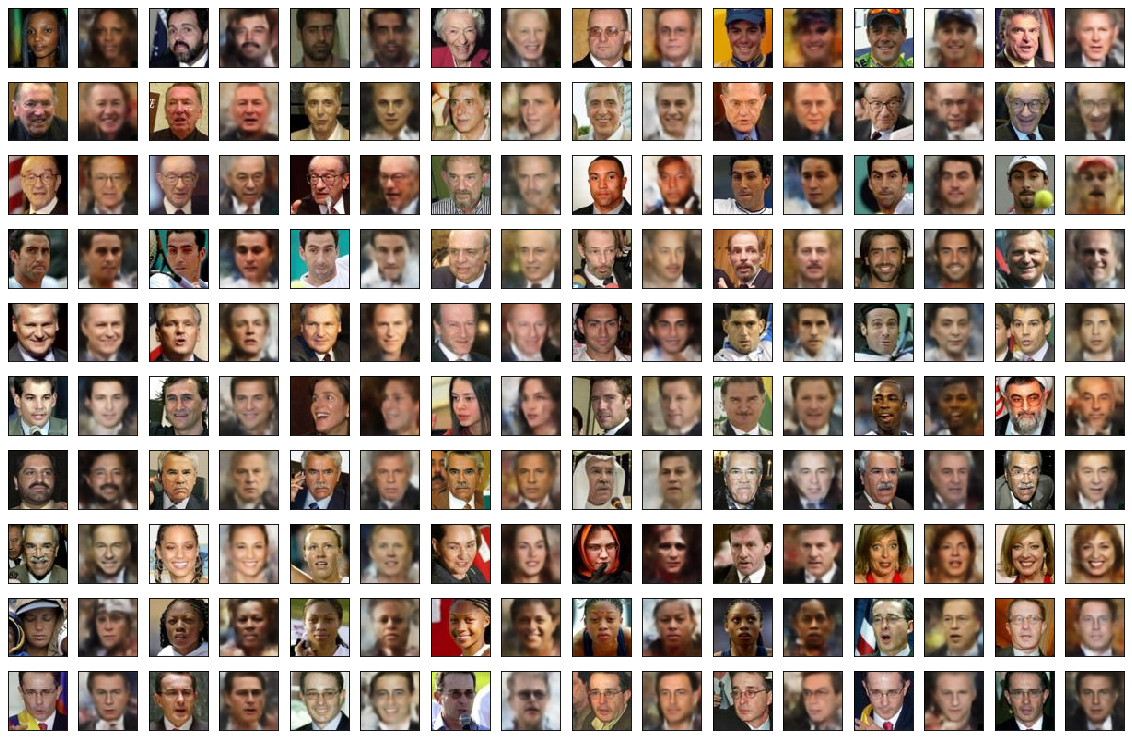

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 12), dpi= 80, facecolor='w', edgecolor='k')

offset = 50
n_row = 16 # how many faces per row
n = 80  # how many faces we will display
reconstructed_imgs = vae.predict([x_test[offset:offset+n], y_test[offset:offset+n]])
for i in range(n):
    # display original
    ax1 = plt.subplot(2*n//n_row, n_row, 2*(i + 1) - 1)
    ax1.imshow((x_test[i + offset] + 1)/2)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)

    # display reconstruction
    ax1 = plt.subplot(2*n//n_row, n_row, 2*(i + 1))
    ax1.imshow((reconstructed_imgs[i] + 1)/2)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
plt.show()

For our next test, we will actually be generating new data. The way we do this is first feed some sample images through the encoder function to get the latent variable representation of the images. Then, we feed these latent variable representations back through the generator function, but with a catch. We modify an attribute of our choice so that the final output image changes accordingly.

In the sample shown here, the attributes for 10 faces are varied racially from whitest to blackest, with 20 images shown in the progression.

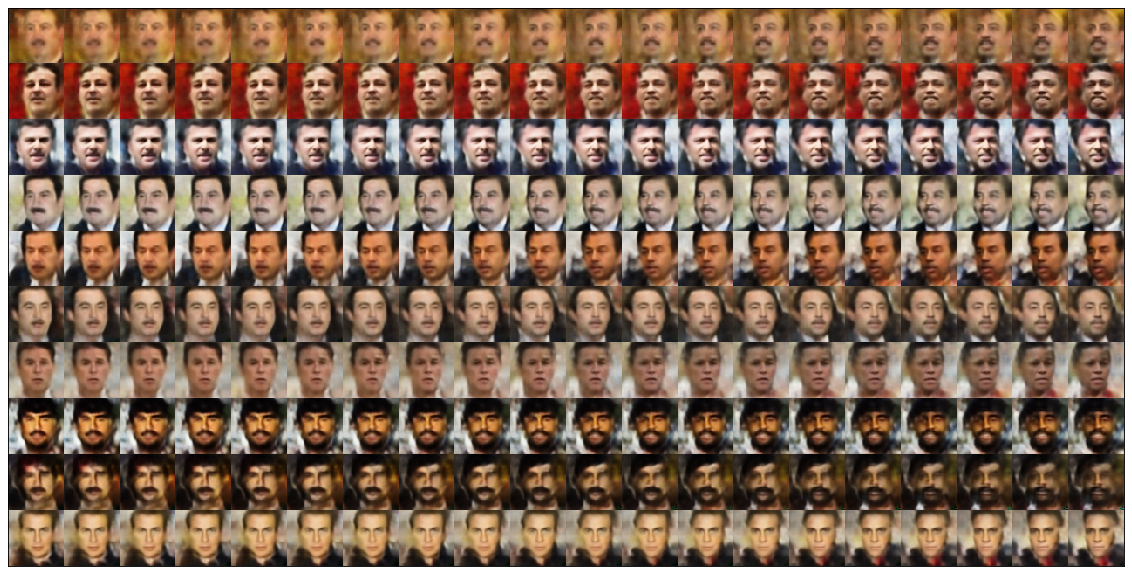

In [25]:
offset = 20
variations = 20 # number of variations of a face
samples = 10 # number of faces used
figure = np.zeros((image_dim * samples, image_dim * variations, cols))
grid_z = np.linspace(y_test.min(axis=0), y_test.max(axis=0), variations)
full_grid_z = np.stack((grid_z, np.flip(grid_z, axis=0)), axis=2)

for index, zi in enumerate(full_grid_z):
    caceres = y_test[offset:samples+offset]
    z_sample = encoder([x_test[offset:samples+offset], y_test[offset:samples+offset], 0])[0]
    caceres[:,2] = zi[2, 1] # increasing vals
    caceres[:,3] = zi[3, 0] # decreasing vals
    x_decoded = generator([z_sample, caceres, 0])[0]
    figure[:,image_dim*index:image_dim*(index+1)] = (np.reshape(x_decoded, (image_dim*samples, image_dim, cols)) + 1)/2

fig = plt.figure(figsize=(18, 12), dpi= 80, facecolor='w', edgecolor='k')
ax3 = fig.add_subplot(111)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
ax3.imshow(figure, cmap='jet')
plt.show()

In the sample shown here, the attributes for 10 faces are varied from sunglasses to no eyewear.

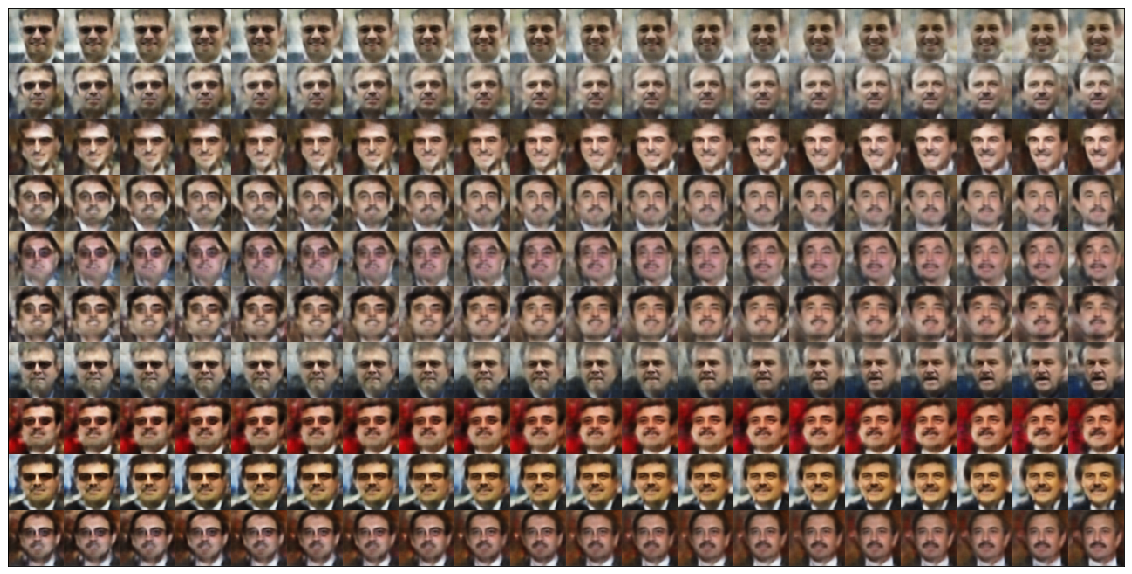

In [28]:
offset = 10
variations = 20 # number of variations of a face
samples = 10 # number of faces used
figure = np.zeros((image_dim * samples, image_dim * variations, cols))
grid_z = np.linspace(y_test.min(axis=0), y_test.max(axis=0), variations)
full_grid_z = np.stack((grid_z, np.flip(grid_z, axis=0)), axis=2)

for index, zi in enumerate(full_grid_z):
    caceres = y_test[offset:samples+offset]
    z_sample = encoder([x_test[offset:samples+offset], y_test[offset:samples+offset], 0])[0]
    caceres[:,15] = zi[15, 1] # increasing vals
    caceres[:,13] = zi[13, 0] # decreasing vals
    x_decoded = generator([z_sample, caceres, 0])[0]
    figure[:,image_dim*index:image_dim*(index+1)] = (np.reshape(x_decoded, (image_dim*samples, image_dim, cols)) + 1)/2

fig = plt.figure(figsize=(18, 12), dpi= 80, facecolor='w', edgecolor='k')
ax3 = fig.add_subplot(111)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
ax3.imshow(figure, cmap='jet')
plt.show()

Here is yet another sample, this time showing progression in maleness from male to female.

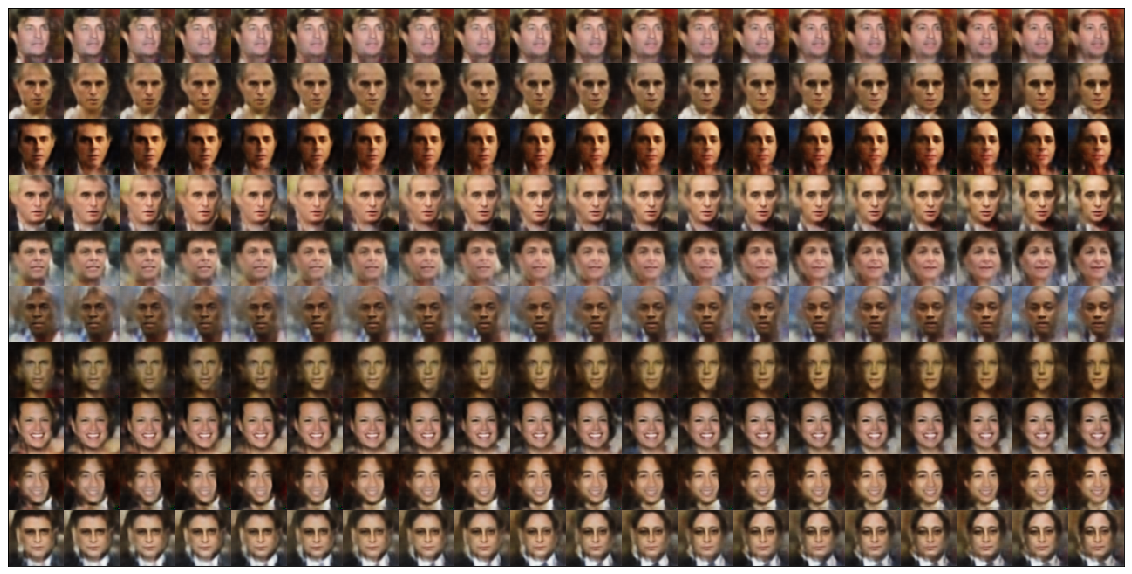

In [31]:
offset = 30
variations = 20 # number of variations of a face
samples = 10 # number of faces used
figure = np.zeros((image_dim * samples, image_dim * variations, cols))
grid_z = np.linspace(y_test.min(axis=0), y_test.max(axis=0), variations)
full_grid_z = np.stack((grid_z, np.flip(grid_z, axis=0)), axis=2)

for index, zi in enumerate(full_grid_z):
    caceres = y_test[offset:samples+offset]
    z_sample = encoder([x_test[offset:samples+offset], y_test[offset:samples+offset], 0])[0]
    caceres[:,0] = zi[0, 1] # increasing vals
    x_decoded = generator([z_sample, caceres, 0])[0]
    figure[:,image_dim*index:image_dim*(index+1)] = (np.reshape(x_decoded, (image_dim*samples, image_dim, cols)) + 1)/2

fig = plt.figure(figsize=(18, 12), dpi= 80, facecolor='w', edgecolor='k')
ax3 = fig.add_subplot(111)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
ax3.imshow(figure, cmap='jet')
plt.show()

As seen clearly, the generator is able to consistently produce images that vary with the attribute information provided to it.